# Ship Detection with YOLO Fine-tuning
## Complete Pipeline: Download → Split → Train → Evaluate

This notebook demonstrates:
1. Downloading the Kaggle ship detection dataset
2. Creating train/test splits
3. Fine-tuning YOLOv8 on the dataset
4. Evaluating results

## Step 1: Install Required Packages

In [16]:
!pip install kagglehub ultralytics opencv-python matplotlib pillow xmltodict scikit-learn


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


## Step 2: Download Dataset from Kaggle

In [17]:
import kagglehub
import os

# Download latest version
path = kagglehub.dataset_download("andrewmvd/ship-detection")
print("Path to dataset files:", path)

# List files in the dataset
print("\nDataset contents:")
for root, dirs, files in os.walk(path):
    for file in files[:10]:  # Show first 10 files
        print(f"  {file}")
    if len(files) > 10:
        print(f"  ... and {len(files) - 10} more files")
    break

Path to dataset files: /Users/raphaelcousin/.cache/kagglehub/datasets/andrewmvd/ship-detection/versions/1

Dataset contents:


## Step 3: Explore Dataset Structure

Total images found: 621
Total annotations found: 621


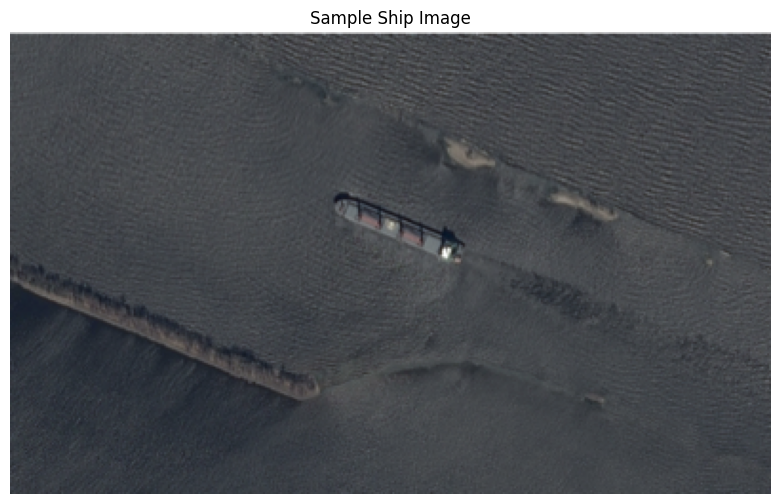

Image size: (400, 243)


In [18]:
import glob
from PIL import Image
import matplotlib.pyplot as plt

# Find all images and annotations
images = glob.glob(os.path.join(path, "**/*.png"), recursive=True) + \
         glob.glob(os.path.join(path, "**/*.jpg"), recursive=True)
annotations = glob.glob(os.path.join(path, "**/*.xml"), recursive=True)

print(f"Total images found: {len(images)}")
print(f"Total annotations found: {len(annotations)}")

# Display a sample image
if images:
    sample_img = Image.open(images[0])
    plt.figure(figsize=(10, 6))
    plt.imshow(sample_img)
    plt.title("Sample Ship Image")
    plt.axis('off')
    plt.show()
    print(f"Image size: {sample_img.size}")

## Step 4: Convert Pascal VOC XML to YOLO Format

In [19]:
import xml.etree.ElementTree as ET
import shutil
from pathlib import Path

def convert_voc_to_yolo(xml_file, img_width, img_height):
    """
    Convert Pascal VOC bounding box to YOLO format.
    YOLO format: <class_id> <x_center> <y_center> <width> <height>
    All values normalized to [0, 1]
    """
    tree = ET.parse(xml_file)
    root = tree.getroot()
    
    yolo_annotations = []
    
    for obj in root.findall('object'):
        # Class is always 0 for 'boat' in this dataset
        class_id = 0
        
        bbox = obj.find('bndbox')
        xmin = float(bbox.find('xmin').text)
        ymin = float(bbox.find('ymin').text)
        xmax = float(bbox.find('xmax').text)
        ymax = float(bbox.find('ymax').text)
        
        # Convert to YOLO format (normalized)
        x_center = ((xmin + xmax) / 2.0) / img_width
        y_center = ((ymin + ymax) / 2.0) / img_height
        width = (xmax - xmin) / img_width
        height = (ymax - ymin) / img_height
        
        yolo_annotations.append(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")
    
    return yolo_annotations

print("Conversion function ready!")

Conversion function ready!


## Step 5: Create Train/Test Split and Organize for YOLO

In [20]:
from sklearn.model_selection import train_test_split
import cv2

# Create YOLO directory structure
dataset_root = Path("ship_yolo_dataset")
dataset_root.mkdir(exist_ok=True)

for split in ['train', 'val']:
    (dataset_root / split / 'images').mkdir(parents=True, exist_ok=True)
    (dataset_root / split / 'labels').mkdir(parents=True, exist_ok=True)

# Match images with their annotations
image_annotation_pairs = []
for img_path in images:
    base_name = Path(img_path).stem
    # Find corresponding XML annotation
    xml_path = None
    for ann in annotations:
        if Path(ann).stem == base_name:
            xml_path = ann
            break
    
    if xml_path:
        image_annotation_pairs.append((img_path, xml_path))

print(f"Found {len(image_annotation_pairs)} image-annotation pairs")

# Split into train (80%) and validation (20%)
train_pairs, val_pairs = train_test_split(image_annotation_pairs, test_size=0.2, random_state=42)

print(f"Training samples: {len(train_pairs)}")
print(f"Validation samples: {len(val_pairs)}")

def process_and_copy_data(pairs, split_name):
    """Process image-annotation pairs and copy to YOLO format"""
    for img_path, xml_path in pairs:
        # Read image to get dimensions
        img = cv2.imread(img_path)
        if img is None:
            continue
        
        height, width = img.shape[:2]
        
        # Convert annotation to YOLO format
        yolo_annotations = convert_voc_to_yolo(xml_path, width, height)
        
        # Copy image
        base_name = Path(img_path).stem
        img_ext = Path(img_path).suffix
        dest_img = dataset_root / split_name / 'images' / f"{base_name}{img_ext}"
        shutil.copy2(img_path, dest_img)
        
        # Save YOLO annotation
        dest_label = dataset_root / split_name / 'labels' / f"{base_name}.txt"
        with open(dest_label, 'w') as f:
            f.write('\n'.join(yolo_annotations))

print("\nProcessing training data...")
process_and_copy_data(train_pairs, 'train')

print("Processing validation data...")
process_and_copy_data(val_pairs, 'val')

print("\n✅ Dataset preparation complete!")

Found 621 image-annotation pairs
Training samples: 496
Validation samples: 125

Processing training data...
Processing validation data...

✅ Dataset preparation complete!


## Step 6: Create YOLO Configuration File

In [ ]:
import yaml

# Create YOLO data configuration
data_config = {
    'path': str(dataset_root.absolute()),
    'train': 'train/images',
    'val': 'val/images',
    'names': {
        0: 'boat'
    },
    'nc': 1  # number of classes
}

config_path = 'ship_data.yaml'
with open(config_path, 'w') as f:
    yaml.dump(data_config, f, default_flow_style=False)

print(f"Configuration saved to {config_path}")
print("\nConfiguration content:")
print(yaml.dump(data_config, default_flow_style=False))

## Step 7: Visualize Some Training Samples with Bounding Boxes

In [ ]:
import matplotlib.patches as patches
import random

def visualize_yolo_annotations(img_path, label_path, num_samples=3):
    """Visualize images with YOLO bounding boxes"""
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    if num_samples == 1:
        axes = [axes]
    
    train_images = list((dataset_root / 'train' / 'images').glob('*'))
    samples = random.sample(train_images, min(num_samples, len(train_images)))
    
    for ax, img_file in zip(axes, samples):
        # Read image
        img = Image.open(img_file)
        width, height = img.size
        
        # Read corresponding label
        label_file = dataset_root / 'train' / 'labels' / f"{img_file.stem}.txt"
        
        ax.imshow(img)
        
        if label_file.exists():
            with open(label_file, 'r') as f:
                for line in f:
                    # Parse YOLO format
                    class_id, x_center, y_center, w, h = map(float, line.strip().split())
                    
                    # Convert back to pixel coordinates
                    x_center *= width
                    y_center *= height
                    w *= width
                    h *= height
                    
                    # Calculate corner coordinates
                    x1 = x_center - w/2
                    y1 = y_center - h/2
                    
                    # Draw bounding box
                    rect = patches.Rectangle((x1, y1), w, h, linewidth=2, 
                                            edgecolor='red', facecolor='none')
                    ax.add_patch(rect)
        
        ax.axis('off')
        ax.set_title(f"Sample: {img_file.name}")
    
    plt.tight_layout()
    plt.show()

visualize_yolo_annotations(None, None, num_samples=3)

## Step 8: Fine-tune YOLOv8 Model

In [ ]:
from ultralytics import YOLO

# Load a pretrained YOLOv8 model (nano version for faster training)
model = YOLO('yolov8n.pt')  # yolov8n = nano (smallest/fastest)

print("Model loaded successfully!")
print(f"Model architecture: {model.model}")

In [ ]:
# Train the model
results = model.train(
    data=config_path,           # Path to data config
    epochs=50,                   # Number of epochs (adjust based on your needs)
    imgsz=640,                   # Image size
    batch=16,                    # Batch size (reduce if out of memory)
    name='ship_detection',       # Experiment name
    patience=10,                 # Early stopping patience
    save=True,                   # Save checkpoints
    plots=True,                  # Generate training plots
    device='cuda' if __import__('torch').cuda.is_available() else 'cpu'  # Use GPU if available
)

print("\n✅ Training complete!")

## Step 9: Evaluate Model on Validation Set

In [ ]:
# Evaluate the model
metrics = model.val()

# Print evaluation metrics
print("\n=== Evaluation Results ===")
print(f"mAP50: {metrics.box.map50:.4f}")        # mAP at IoU=0.5
print(f"mAP50-95: {metrics.box.map:.4f}")       # mAP at IoU=0.5:0.95
print(f"Precision: {metrics.box.mp:.4f}")
print(f"Recall: {metrics.box.mr:.4f}")

## Step 10: Visualize Training Results

In [ ]:
from IPython.display import Image as IPImage, display

# Display training curves
results_dir = Path('runs/detect/ship_detection')

print("Training Results:")
print("\n1. Results Plot:")
display(IPImage(filename=str(results_dir / 'results.png')))

print("\n2. Confusion Matrix:")
if (results_dir / 'confusion_matrix.png').exists():
    display(IPImage(filename=str(results_dir / 'confusion_matrix.png')))

## Step 11: Test Predictions on Sample Images

In [ ]:
# Load the best trained model
best_model = YOLO('runs/detect/ship_detection/weights/best.pt')

# Get some validation images
val_images = list((dataset_root / 'val' / 'images').glob('*'))[:5]

# Run inference
print("Running predictions on sample validation images...\n")

for img_path in val_images:
    results = best_model.predict(source=str(img_path), save=True, conf=0.25)
    
    # Display results
    for result in results:
        boxes = result.boxes
        print(f"Image: {img_path.name}")
        print(f"  Detected {len(boxes)} boat(s)")
        for box in boxes:
            conf = box.conf[0]
            print(f"    - Confidence: {conf:.2f}")
    print()

print(f"\nPredictions saved to: runs/detect/predict/")

## Step 12: Display Prediction Results

In [ ]:
# Display predictions
predict_dir = Path('runs/detect/predict')
predicted_images = list(predict_dir.glob('*.png')) + list(predict_dir.glob('*.jpg'))

if predicted_images:
    num_display = min(3, len(predicted_images))
    fig, axes = plt.subplots(1, num_display, figsize=(15, 5))
    if num_display == 1:
        axes = [axes]
    
    for ax, img_path in zip(axes, predicted_images[:num_display]):
        img = Image.open(img_path)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"Prediction: {img_path.name}")
    
    plt.tight_layout()
    plt.show()
else:
    print("No prediction images found. Check the predict directory.")

## Step 13: Save Model Summary

In [ ]:
# Print model summary
print("\n=== Model Summary ===")
print(f"Model: YOLOv8n (nano)")
print(f"Dataset: Ship Detection (Kaggle)")
print(f"Training samples: {len(train_pairs)}")
print(f"Validation samples: {len(val_pairs)}")
print(f"Number of classes: 1 (boat)")
print(f"Best model saved at: runs/detect/ship_detection/weights/best.pt")
print(f"\nFinal metrics:")
print(f"  mAP50: {metrics.box.map50:.4f}")
print(f"  mAP50-95: {metrics.box.map:.4f}")
print(f"  Precision: {metrics.box.mp:.4f}")
print(f"  Recall: {metrics.box.mr:.4f}")

## 🎉 Complete!

### What you've accomplished:
1. ✅ Downloaded ship detection dataset from Kaggle
2. ✅ Converted annotations from Pascal VOC to YOLO format
3. ✅ Created train/validation split (80/20)
4. ✅ Fine-tuned YOLOv8 on ship detection
5. ✅ Evaluated the model performance
6. ✅ Visualized predictions

### Next steps for students:
- Experiment with different YOLO models (yolov8s, yolov8m, yolov8l)
- Adjust hyperparameters (epochs, batch size, learning rate)
- Try data augmentation techniques
- Test on their own ship images
- Compare with other object detection models (Faster R-CNN, RetinaNet)